# Prototipo de MoDem especializado en la técnica LoRa para la transmisión y recepción en SDRs (V 0.1.0)



## Implementación del MoDem LoRa


La modulación LoRa se podría catalogar como una **manera sistemática de encapsular símbolos** a través de distintas configuraciones en la evolución lineal de la frecuencia para una señal chirp, actuante de portadora.



### Definición, implementación e implicancias de los parámetros

Para poder llevar a cabo la implementación del MoDem, es necesario tener en cuenta aquellos parámetros del sistema de comunicación que se deban mantener a lo largo de cada transmisión. Así como en AM uno sintoniza a una frecuencia específica para estar en sintonía el transmisor con el receptor, en LoRa deberemos manifestar estos parámetros *externos* (omitiendo el Coding Rate por ahora):

- Bandwidth (Ancho de Banda): El ancho de banda especificado para una transimisión LoRa deberá ser especificado ya que definirá los límites inferiores y superiores en los que la frecuencia presentará esta variación. Es decir, si establecemos un ancho de banda de por ejemplo $Bw = 125$ kHz, se tendrá entonces una evolución de la frecuencia siempre entre esos valores. 
  
- Spreading Factor (Factor de expansión): Este parámetro engloba dos responsabilidades: Representar la cantidad de bits que se podrán transmitir en un símbolo y que tanto se esparcirá en el tiempo (es decir, su duración) la transmisión del símbolo.

- Resolución entre chips: Para esta implementación, se dará la posibilidad de *"tender a lo analógico* a través del uso de un parámetro de resolución, que permitirá expandir los puntos renderizados (más allá de los mínimos). Se representará en el álgebra como $R_B$ donde la $R$ se refiere a "resolución" y la $B$ se refiere al término anglosajón "in-between" de "entre".
  
   **OJO CON USAR NP.LINSPACE y los impares**

Además, podemos catalogar a los parámetros *internos* como aquellos que se deducen directamente a partir de los parámetros internos antes mencionados, así poder reutilizarlos como variables una vez se realice el código:

- Chips y Número de Chips: El chip representa la unidad fundamental de información, resultante de la expansión realizada por el $SF$. Es equivalente (aunque no son sinónimos) con la cantidad de combinaciones posibles para transmitir un símbolo, a saber: $N_{C}= 2^{SF}$. Es decir, que el chip es item de menor expresión en la secuencia de evolución de frecuencia a lo largo del tiempo. (Es decir, la mínima muestra que mantiene el concepto de la técnica LoRa)

- Samples Per Symbol (Muestras por símbolo): Representa cuantos puntos se renderizarán en la función discreta. Para ello, podremos calcularla como: $SPS = N_{C} \cdot R_B$. Con que las muestras por símbolo equivalgan al número de chips, ya se tiene una representación suficiente de cada chip. Sin embargo, se puede multiplicar esto por un factor de resolución para aumentar el número de muestras.

- Symbol Duration (duración por símbolo): Representa cuanto tiempo le tomará a nuestro chirp barrer todo el ancho de banda. Este se calcula como: $T_S= \frac{N_{C}}{Bw}$
- Frequency Slope (pendiente de frecuencia): Representa la tasa de cambio de la evolución lineal de nuestra frecuencia. Se calcula como cualquier otra pendiente, tomándonos la libertad de asumir como 0 el símbolo transmitido, para evitar introducir la discontinuidad, aprovechando de que la pendiente será constnate incluso en presencia de discontinuidades:
  
    $m_f = \frac{\Delta Y}{\delta X} =  \frac{(Bw - 0)}{\frac{N_{C}}{Bw}-0} = \frac{Bw^2}{N_c}$

### Evolución de la Frecuencia instantánea a través del tiempo

Para poder determinar la evolución lineal de la frecuencia instantánea a lo largo del tiempo en base a los símbolos a enviar, se utilizará un simple algoritmo que empleando la duración de símbolo, la pendiente y la ordenada al origen de cada símbolo.

In [35]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt

class LoraReservedArtifacts(Enum):
    FULL_UPCHIRP = 0
    FULL_DOWNCHIRP = 1
    QUARTER_DOWNCHIRP = 2


class LoraModulator:
    def __init__(self, spreading_factor, bandwidth, resolution_between_chips):
        # LoRa technique external parameters
        self.spreading_factor = spreading_factor
        self.bandwidth = bandwidth
        self.resolution_between_chips = resolution_between_chips

        # Lora technique internal parameters
        self.__chips_number = 2 ** spreading_factor
        self.__symbol_duration = self.__chips_number / bandwidth
        self.__samples_per_symbol = int(self.__chips_number * resolution_between_chips)
        self.__sampling_period = self.__symbol_duration / self.__samples_per_symbol
        self.__frequency_slope = (bandwidth ** 2) / self.__chips_number

    # temp
    def validate(self):
        assert self.spreading_factor in [7, 8, 9, 10, 11, 12]
        assert self.bandwidth in [125, 250, 500]
        assert self.resolution_between_chips in [4, 8]

    def generate_frequency_evolution_across_time(self, symbols):

        frequency_evolution = []
        time_axis = []
        current_offset = 0
        
        for symbol in symbols:
            current_slope = self.__frequency_slope

            

            symbol_time_axis = np.arange(current_offset, current_offset + self.__symbol_duration, self.__sampling_period)

            print("time for this symbol: ","[",symbol_time_axis[0],"...",symbol_time_axis[-1],"]")

            print("current offset for this symbol (should match the next value of the last time in the previous symbol):",current_offset)

            A = False
            time_axis.append
            if symbol == LoraReservedArtifacts.FULL_UPCHIRP:
                symbol = 0

            elif symbol == LoraReservedArtifacts.FULL_DOWNCHIRP:
                symbol = 2**self.spreading_factor - 1
                current_slope = - current_slope
            
            elif symbol == LoraReservedArtifacts.QUARTER_DOWNCHIRP:
                symbol = 2**self.spreading_factor - 1
                current_slope = - current_slope
                quarter_cycle_max_index = int(len(symbol_time_axis)//4 + 1)
                symbol_time_axis = symbol_time_axis[:quarter_cycle_max_index]
                A = True

            if A:
                print(len(symbol_time_axis))
                print("NEW time for this symbol: ","[",symbol_time_axis[0],"...",symbol_time_axis[-1],"]")

            # Not using chips number due to theorical reasons (equivalent in value, not in meaning)
            y_intercept = symbol * ( self.bandwidth / (2**self.spreading_factor - 1) )
            print("y intercept: ",y_intercept)

            for i in range(len(symbol_time_axis)):
                instantaneous_frequency = y_intercept + current_slope * (symbol_time_axis[i] - current_offset)

                if instantaneous_frequency > self.bandwidth:
                    # Not necesarry to take into account multiples of bandwidth, as the duration of the chirp is limited 
                    # (i think)
                    instantaneous_frequency -= self.bandwidth

                frequency_evolution.append(instantaneous_frequency)
            
            time_axis.extend(symbol_time_axis)
            
            time_stop = current_offset + self.__symbol_duration + self.__sampling_period
            current_offset = time_stop
            print("end it loop")

        return time_axis, frequency_evolution
    def generate_chirp_from_frequency_evolution(self, time_axis, frequency_evolution):
        pass
        

        

time for this symbol:  [ 0.0 ... 1.016 ]
current offset for this symbol (should match the next value of the last time in the previous symbol): 0
33
NEW time for this symbol:  [ 0.0 ... 0.256 ]
y intercept:  125.0
end it loop
time for this symbol:  [ 1.032 ... 2.048000000000001 ]
current offset for this symbol (should match the next value of the last time in the previous symbol): 1.032
y intercept:  0.0
end it loop


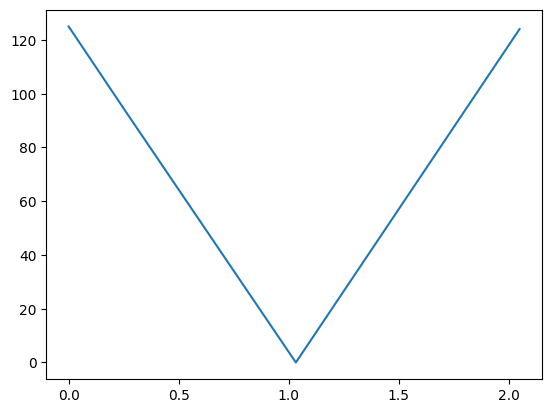

In [36]:
l = LoraModulator(7, 125, 1)
t,f = l.generate_frequency_evolution_across_time([LoraReservedArtifacts.QUARTER_DOWNCHIRP,0])
plt.plot(t,f)

In [ ]:
    # def __init__(self):
    #     self.__modem = None
    #     self.__modem = __import__('modem')
    #     self.__modem = self.__modem.Modem()
    #     self.__modem.set_mode('lora')
    #     self.__modem.set_freq(868.1)
    #     self.__modem.set_pwr(14)
    #     self.__modem.set_sf(12)
    #     self.__modem.set_bw(125)
    #     self.__modem.set_cr(4/5)
    #     self.__modem.set_sync_word(0x12)
    #     self.__modem.set_iq_invert(False)
    #     self.__modem.set_crc(True)
    #     self.__modem.set_preamble(8)
    #     self.__modem.set_header(True)
    #     self.__modem.set_payload_length(0)
    #     self.__modem.set_timeout(1000)
    #     self.__modem.set_sync_word(0x12)
    #     self.__modem.set_iq_invert(False)
    #     self.__modem.set_crc(True)
    #     self.__modem.set_preamble(8)
    #     self.__modem.set_header(True)
    #     self.__modem.set_payload_length(0)
    #     self.__modem.set_timeout(1000)

    # def send(self, data):
    #     self.__modem.send(data)

    # def receive(self):
    #     return self.__modem.receive()

    # def close(self):
    #     self.__modem.close()

In [ ]:
import numpy as np
for b in range(1, 10):
    a = np.linspace(0, 1*b, 2*b)
    print(a)

[0. 1.]
[0.         0.66666667 1.33333333 2.        ]
[0.  0.6 1.2 1.8 2.4 3. ]
[0.         0.57142857 1.14285714 1.71428571 2.28571429 2.85714286
 3.42857143 4.        ]
[0.         0.55555556 1.11111111 1.66666667 2.22222222 2.77777778
 3.33333333 3.88888889 4.44444444 5.        ]
[0.         0.54545455 1.09090909 1.63636364 2.18181818 2.72727273
 3.27272727 3.81818182 4.36363636 4.90909091 5.45454545 6.        ]
[0.         0.53846154 1.07692308 1.61538462 2.15384615 2.69230769
 3.23076923 3.76923077 4.30769231 4.84615385 5.38461538 5.92307692
 6.46153846 7.        ]
[0.         0.53333333 1.06666667 1.6        2.13333333 2.66666667
 3.2        3.73333333 4.26666667 4.8        5.33333333 5.86666667
 6.4        6.93333333 7.46666667 8.        ]
[0.         0.52941176 1.05882353 1.58823529 2.11764706 2.64705882
 3.17647059 3.70588235 4.23529412 4.76470588 5.29411765 5.82352941
 6.35294118 6.88235294 7.41176471 7.94117647 8.47058824 9.        ]
